In [1]:
!nvidia-smi

Tue Dec  4 15:24:26 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.54                 Driver Version: 396.54                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:0A:00.0 Off |                  N/A |
|  9%   48C    P8    19W / 250W |  10912MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:0B:00.0 Off |                  N/A |
| 35%   57C    P8    22W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [3]:
from fastai import *
from fastai.vision import *
import pathlib

In [4]:
bs = 32

In [5]:
path = pathlib.Path('/media/ssd_working_space/karmanya/data/armbarvsheelhookclean/')

In [24]:
for c in ['armbar', 'heelhook']:
    print(c)
    verify_images(path/'Test'/c, delete=True, max_size=500)

armbar


heelhook


In [25]:
images = ImageDataBunch.from_folder(path, train='Train', valid='Test', ds_tfms=get_transforms(), size=224,
                                    bs=bs).normalize(imagenet_stats)

In [26]:
images.classes

['armbar', 'heelhook']

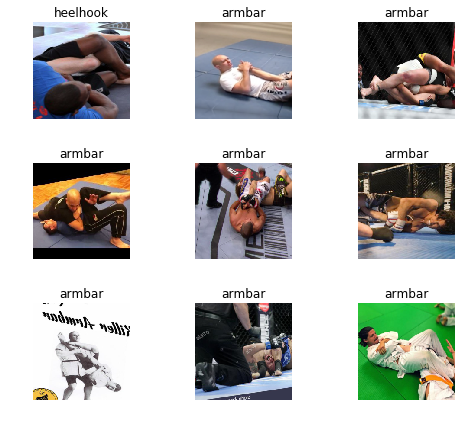

In [27]:
images.show_batch(rows=3, figsize=(7,6))

In [28]:
learn = create_cnn(images, models.resnet34, metrics=error_rate)

In [29]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,0.787504,0.499844,0.271676
2,0.693922,0.326611,0.132948
3,0.613547,0.326184,0.144509
4,0.564280,0.291147,0.127168


In [30]:
learn.save('armbarvsheelhookstage1')

In [31]:
interp = ClassificationInterpretation.from_learner(learn)

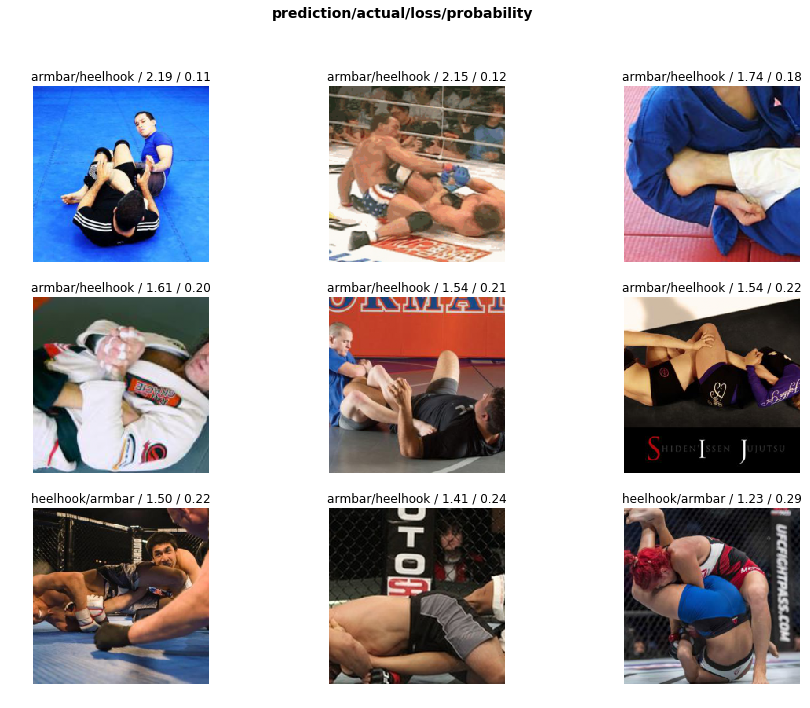

In [34]:
interp.plot_top_losses(9, figsizeb=(15,11))

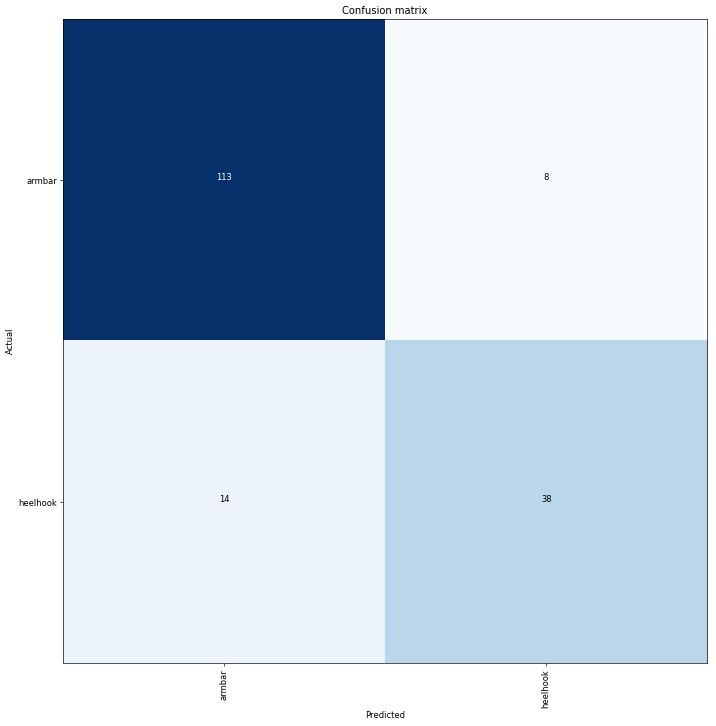

In [33]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [37]:
interp.most_confused(min_val=2)
interp.most_confused??

In [38]:
learn.unfreeze()

In [39]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,0.454253,0.253241,0.104046


In [40]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


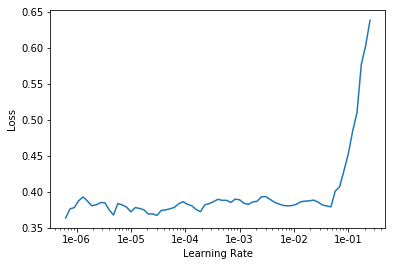

In [41]:
learn.recorder.plot()

In [42]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.380915,0.249151,0.104046
2,0.382589,0.246565,0.104046
3,0.403423,0.239798,0.104046
4,0.405999,0.234758,0.104046
5,0.395182,0.229097,0.098266
6,0.395749,0.226122,0.092486
7,0.391762,0.222595,0.098266
8,0.393590,0.221521,0.092486
9,0.391377,0.222368,0.080925
10,0.389545,0.216003,0.086705


In [43]:
learn.save('armbarvsheelhookpostunfreeze')

In [45]:
interp = ClassificationInterpretation.from_learner(learn)

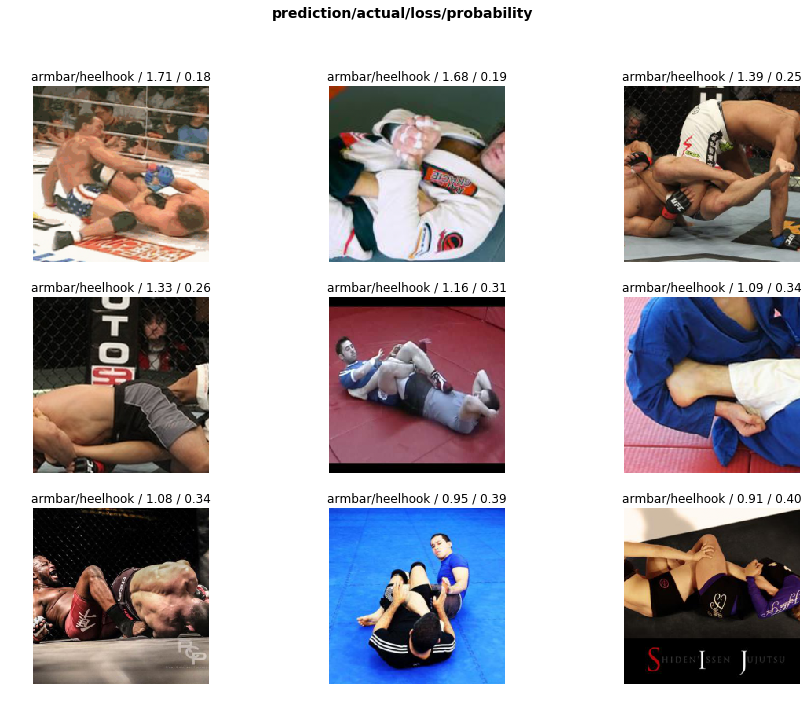

In [47]:
interp.plot_top_losses(9, figsize=(15,11))

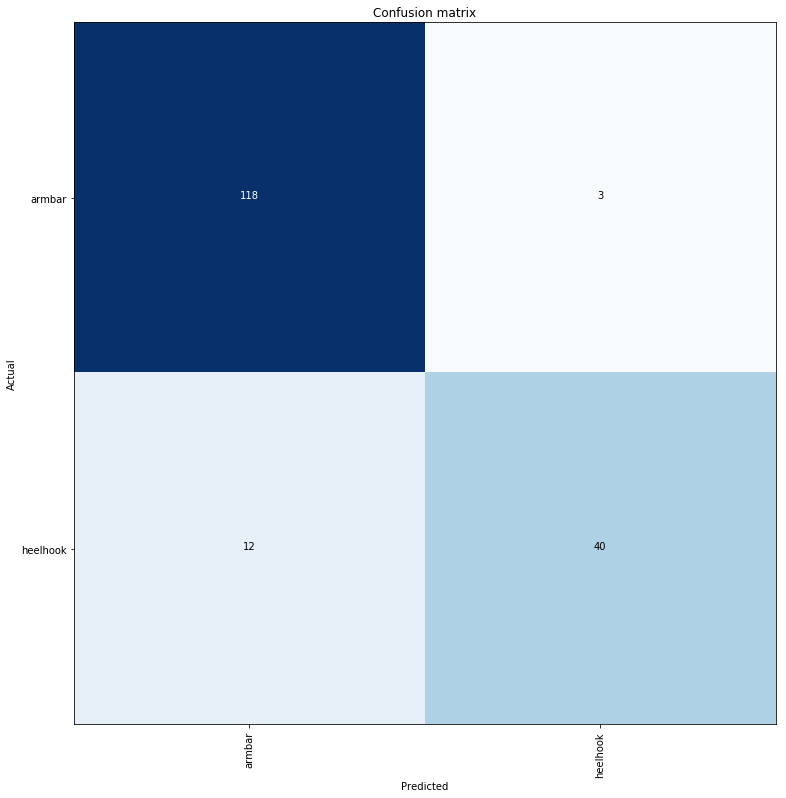

In [49]:
interp.plot_confusion_matrix(figsize=(11,11))

In [52]:
re50 = create_cnn(images, models.resnet50, metrics=error_rate)

In [54]:
re50.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate
1,0.208315,0.091955,0.011561
2,0.205535,0.086057,0.011561
3,0.227782,0.095940,0.017341
4,0.239639,0.113993,0.040462
5,0.230998,0.087987,0.034682
6,0.231538,0.065890,0.023121
7,0.210981,0.056774,0.017341
8,0.191536,0.046392,0.011561
9,0.173962,0.038866,0.000000
10,0.164797,0.040167,0.000000


In [56]:
interp = ClassificationInterpretation.from_learner(re50)

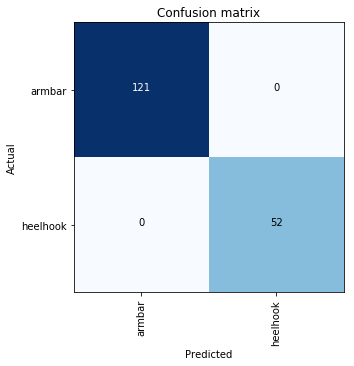

In [58]:
interp.plot_confusion_matrix(figsize=(5,5))

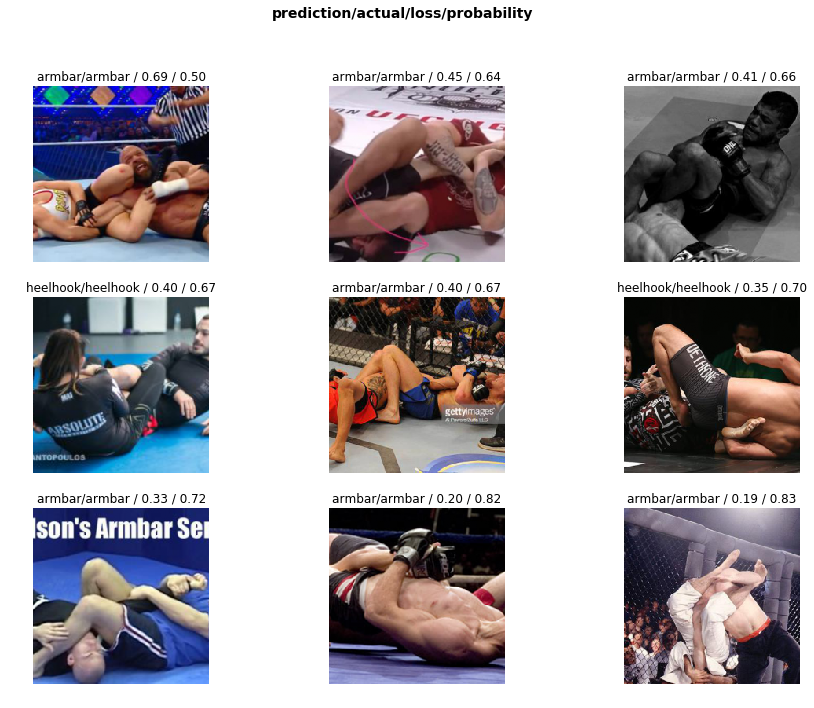

In [60]:
interp.plot_top_losses(9, figsize=(15,11))

In [61]:
re50.save('res50armbarvsheelhookperfect')